In [1]:
import numpy as np
import camb
import matplotlib.pyplot as plt

In [7]:
def get_eq(om0h2, theta):
    z_eq = 2.5*1e4 * om0h2 / theta**4
    k_eq = 7.46*1e-2 * om0h2 / theta**2  # in Mpc^-1
    return z_eq, k_eq
def get_zdrag(om0h2, ombh2):
    b1 = 0.313*(om0h2)**-0.419*(1+0.607*om0h2**0.674)
    b2 = 0.238*(om0h2)**0.223
    zdrag = 1291*om0h2**0.251/(1+0.659*om0h2**0.828)*(1+b1*ombh2**b2)
    return zdrag
def get_s(om0h2, ombh2, theta):
    zdrag = get_zdrag(om0h2, ombh2)
    z_eq, k_eq = get_eq(om0h2, theta)
    Req = 31.5*ombh2*(theta)**-4 * (z_eq/1e3)**-1
    Rdrag = 31.5*ombh2*(theta)**-4 * (zdrag/1e3)**-1
    s = (
    (2./(3*k_eq))*np.sqrt(6./Req)*
    np.log((np.sqrt(1+Rdrag) + np.sqrt(Rdrag + Req))/(1+np.sqrt(Req)))
    )
    return s

In [11]:
theta = 2.728/2.7
keq = get_eq(0.4, theta)[1]
s = get_s(0.4, 0.16, theta)
print(keq*s/np.pi)

0.7091165055602682


In [ ]:
class EisensteinHu:
    def __init__(self, ombh2=0.022, omch2=0.122,h=0.675, mnu=0.06, ns=0.965, As=2e-9, tau=0.06, TCMB=2.728):
        self.name = "Eisenstein-Hu"
        self.params = {
            'ombh2': ombh2,
            'omch2': omch2,
            'h': h,
            'mnu': mnu,
            'ns': ns,
            'As': As,
            'tau': tau,
            'TCMB': TCMB
        }
        self.om0h2 = ombh2 + omch2
        self.theta = TCMB/2.7
        self.zeq = 2.5*1e4 * self.om0h2 * (self.theta)**-4
        self.keq = 7.46*1e-2 * self.om0h2*(self.theta)**-2 # in Mpc^-1

        # k_silk calculation
        self.ksilk = 1.6*ombh2**0.52*self.om0h2**0.73*(1+(10.4*self.om0h2)**-0.95) # in Mpc^-1

    # zdrag calculation
    def get_zdrag(self):
        self.ombh2 = self.params['ombh2']
        b1 = 0.313*(self.om0h2)**-0.419*(1+0.607*self.om0h2**0.674)
        b2 = 0.238*(self.om0h2)**0.223
        self.zdrag = 1291*self.om0h2**0.251/(1+0.659*self.om0h2**0.828)*(1+b1*self.ombh2**b2)
        return self.zdrag
    
    # s calculation    
    def get_s(self):
        """
        calculates the sound horizon at drag epoch in comoving distance


        """
        self.zdrag = self.get_zdrag() # includes self.zdrag, self.ombh2
        self.Req = 31.5*self.ombh2*(self.theta)**-4 * (1e3/self.zeq)
        self.Rdrag = 31.5*self.ombh2*(self.theta)**-4 * (1e3/self.zdrag)
        self.s = (
        (2./(3*self.keq))*np.sqrt(6./self.Req)*
        np.log((np.sqrt(1+self.Rdrag) + np.sqrt(self.Rdrag + self.Req))/(1+np.sqrt(self.Req)))
        )
        return self.s
    # 
    def Transfer_c(self,k):
        
    def Transfer_function(self, k):
        self.omch2 = self.params['omch2']
        # calculate q and s
        
        s = self.get_s() # updates self.zdrag, self.ombh2, self.s

        # calculate nuisance parameters for alpha_c [11]
        a1 = (46.9*self.om0h2)**0.670*(1+(32.1*self.om0h2)**-0.532)
        a2 = (12.0*self.om0h2)**0.424*(1+(45.0*self.om0h2)**-0.582)
        # calculate alpha_c [12]
        alpha_c = a1**-(self.ombh2/self.om0h2) * a2**-(self.ombh2/self.om0h2)**3
        print("alpha_c:", alpha_c)

        # calculate nuisance parameters for beta_c [12]
        b1 = 0.944*(1+(458*self.om0h2)**-0.708)**-1
        b2 = (0.395*self.om0h2)**-0.0266
        # calculate beta_c [12]
        beta_c = 1/(1+b1*((self.omch2/self.om0h2)**b2 - 1))
        print("beta_c:", beta_c)

        # calculate T_c
        def Ttilde0(k, alpha_c, beta_c): # [19]
            q = k/(13.41*self.keq) # [10]
            C = 14.2/alpha_c+386./(1+69.9*q**1.08)
            return np.log(np.e+1.8*beta_c*q)/(np.log(np.e+1.8*beta_c*q)+C*q**2)
        f = 1/(1+(k*s/5.4)**4) # [18]

        T_c = f*Ttilde0(k, 1, beta_c) + (1-f)*Ttilde0(k, alpha_c, beta_c) # [17]


        # calculate alpha_b
        def G(y): # [15]
            return y*(-6.*np.sqrt(1+y)+(2+3*y)*np.log((np.sqrt(1+y)+1)/np.sqrt(1+y)-1))
        alpha_b = 2.07*self.keq*s*(1+self.Rdrag)**-(3/4)*G((1+self.zeq)/(1+self.zdrag)) # [14]
        def j0(x):
            return np.sin(x)/x
        # calculate T_b # [23]
        beta_node = 8.41*self.om0h2**0.435 # [23]
        stilde = s/(1+(beta_node/k/s)**3)**(1/3) # [22]
        beta_b = 0.5 + self.ombh2/self.om0h2 + (3 - 2*self.ombh2/self.om0h2)*np.sqrt((17.2*self.om0h2)**2 + 1) # [24]

        T_b = ((Ttilde0(k,1,1)/(1+(k*s/5.2)**2)) + (alpha_b/(1+(beta_b/(k*s))**3)*np.exp(-(k/self.ksilk)**1.4)))*j0(k*stilde) # [21]

        T_k = self.ombh2/self.om0h2*T_b + self.omch2/self.om0h2*T_c
        return T_k
    
    def Power_spectrum(self, k, kpivot=0.05):
        self.ns = self.params['ns']
        self.As = self.params['As']
        T_k = self.Transfer_function(k)
        P_k = self.As*(k/kpivot)**(self.ns-1)*T_k**2
        return P_k
    

alpha_c: 0.24307357293425647
beta_c: 6.722865890157839


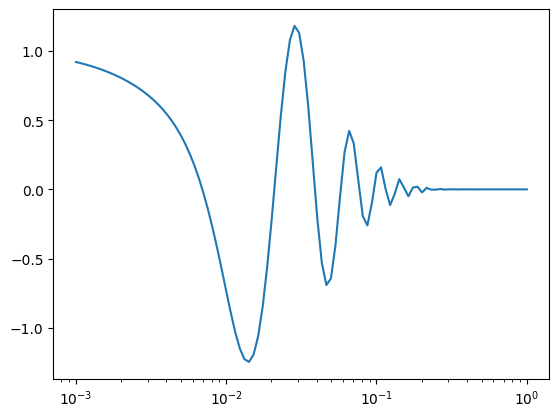

In [17]:
om0h2 = 0.2*0.5**2
ombh2 = om0h2*1
pars = EisensteinHu(ombh2=ombh2, omch2=om0h2-ombh2, h=0.5)
karr = np.logspace(-3,0,100)
p = pars.Transfer_function(karr)
plt.plot(karr, p)
plt.xscale('log')
plt.show()


In [ ]:
4